In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [33]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np

In [66]:
df1 = pd.read_csv('/content/gdrive/MyDrive/ASOS/CSV/TRAIN.csv', encoding = 'UTF-8')
df2 = pd.read_csv('/content/gdrive/MyDrive/ASOS/CSV/TEST.csv', encoding = 'UTF-8')

# 다운 샘플링을 진행

기존 SMOTE를 사용한 경우와 다중분류 모델의 경우에 성능이 좋지 못했기 때문에 가장 좋은 성능을 뽑아 낼 수 있었던 다운샘플링 방식과 라벨을 새로 지정한 이진분류 모델의 형태를 만들기위한 전처리 진행

In [67]:
data3 = df1['SPI'] == 3
data13 = df1[data3]
data13 = data13.sample(n = 10000)

data4 = df1['SPI'] == 4
data14 = df1[data4]
data14 = data14.sample(n = 10000)

data5 = df1['SPI'] == 5
data15 = df1[data5]
data15 = data15.sample(n = 4000)

data2 = df1['SPI'] <= 2
data12 = df1[data2]

data6 = df1['SPI'] >= 6
data16 = df1[data6]

data_all = pd.concat([data12, data13, data14, data15, data16], ignore_index = True)

new_range11 = {'SPI' : {0 : 0, 1 : 0 , 2: 0, 3 : 1, 4 : 1, 5 : 1, 6 : 1, 7 : 1}}

df7 = data_all.replace(new_range11)

df8 = df2.replace(new_range11)

In [68]:
df1.columns

Index(['stnId', 'tm', 'stnNm', 'avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs',
       'avgTd', 'avgRhm', 'avgPa', 'avgTs', 'SPI'],
      dtype='object')

# COLUMN 세부 내용

1. avgTa : 평균온도
2. minTa : 최저온도
3. maxTa : 최고온도
4. sumRn : 일강수량
5. avgWs : 평균풍속
6. avgTd : 평균 이슬점온도
7. avgRhm : 평균 상대습도
8. avgPa : 평균 현지기압
9. avgTs : 평균 지면온도
10. SPI : 가뭄지수

In [69]:
train = df7.drop(['stnId', 'tm', 'stnNm'], axis = 1)
test = df8.drop(['stnId', 'tm', 'stnNm'], axis = 1)

In [70]:
X_train = train.drop('SPI', axis = 1)
y_train = train['SPI']
X_test = test.drop('SPI', axis = 1)
y_test = test['SPI']

In [71]:
sc = StandardScaler()

In [72]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

In [137]:
clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
clf.fit(X_train_sc, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [138]:
predict = clf.predict(X_test_sc)
print(accuracy_score(y_test, predict))

0.7508951137320977


In [140]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.21      0.33      0.25      2431
           1       0.89      0.81      0.85     16561

    accuracy                           0.75     18992
   macro avg       0.55      0.57      0.55     18992
weighted avg       0.80      0.75      0.77     18992



위 처럼 precision 에서 0의 값이 0.21이 되는 이유는 타겟 값 0과 1 값에 대한 분포된 항목 수가 차이가 크기 때문이다.

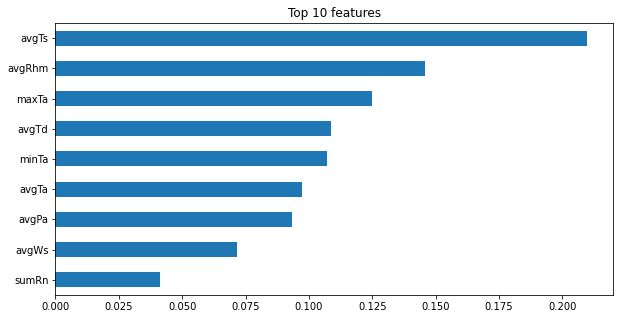

In [141]:
importances = pd.Series(clf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh()

특성 중요도에 대한 결과를 보고 모델링 전처리 부분을 재 확립하려 했으나 큰 차이가 없으며 현재 데이터에서 뺄 필요가 없다고 판단하게 됨

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix')

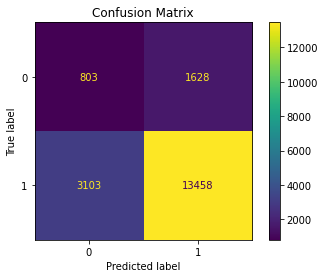

In [142]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

label = [0, 1]
plot = plot_confusion_matrix(clf,
                             X_test_sc, y_test,
                             display_labels = label,
                             normalize = None)
plot.ax_.set_title('Confusion Matrix')

위 경우처럼 Confusion Matrix 를 진행한 결과 현재 가뭄의 상태인 0 값을 진짜 0으로 판단한 값과 1값으로 판단한 결과의 비율이 1 : 2 정도의 형태를 보이는데, 그렇기에 가뭄평가에 대한 정확한 성능은 35% 정도의 성능을 보인다고 볼 수 있으나, 가뭄이 아닌 상태에 대한 평가 성능은 오히려 80% 이상의 평가를 보인다.

# 임계치 조절을 통한 분석

In [143]:
predict_prob = clf.predict_proba(X_test_sc)[:, 1]

In [150]:
threshold = 0.46

prediction = predict_prob > threshold

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.24      0.24      0.24      2431
           1       0.89      0.89      0.89     16561

    accuracy                           0.81     18992
   macro avg       0.57      0.57      0.57     18992
weighted avg       0.81      0.81      0.81     18992



In [151]:
confusion_matrix(y_test, prediction)

array([[  594,  1837],
       [ 1857, 14704]])

이처럼 나타나는데, 이 경우에는 가뭄 평가에 대한 성능은 올라갈 지 모르지만 가뭄이 아닌 상태에 대한 평가가 굉장히 낮게 평가된다.

이런 형태에 있어서 가뭄에 대한 평가 성능을 올린다고 억지로 임계치를 조절할 경우 역으로 서비스 과정에서 가뭄이 아닌 습한 상태의 지면에 물을 더 뿌려야 한다는 정보를 제공한다는 등의 역으로 안좋은 서비스를 제공할 가능성이 높아지기 때문에 임계치에 대한 강제적 성능 향상의 경우는 옳지 못한 방향이라고 판단된다.

In [111]:
clf1 = RandomForestClassifier(random_state = 42)
clf1.fit(X_train_sc, y_train)

RandomForestClassifier(random_state=42)

In [112]:
predict1 = clf1.predict(X_test_sc)
print(accuracy_score(y_test, predict1))

0.6526958719460826


In [113]:
print(classification_report(y_test, predict1))

              precision    recall  f1-score   support

           0       0.17      0.44      0.25      2431
           1       0.89      0.68      0.77     16561

    accuracy                           0.65     18992
   macro avg       0.53      0.56      0.51     18992
weighted avg       0.80      0.65      0.71     18992



In [117]:
dists = {
    'max_depth' : [3,5,10,15],
    'n_estimators' : [80, 100, 150, 200]
}

clf2= RandomizedSearchCV(
    clf1,
    param_distributions = dists,
    n_iter = 50,
    cv = 5,
    scoring = 'f1',
    verbose = 1,
  )

clf2.fit(X_train_sc, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 16 candidates, totalling 80 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [3, 5, 10, 15],
                                        'n_estimators': [80, 100, 150, 200]},
                   scoring='f1', verbose=1)

In [118]:
predict2 = clf2.predict(X_test_sc)
print(accuracy_score(y_test, predict2))

0.8225042122999158


In [119]:
print(classification_report(y_test, predict2))

              precision    recall  f1-score   support

           0       0.24      0.18      0.21      2431
           1       0.88      0.92      0.90     16561

    accuracy                           0.82     18992
   macro avg       0.56      0.55      0.55     18992
weighted avg       0.80      0.82      0.81     18992



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix')

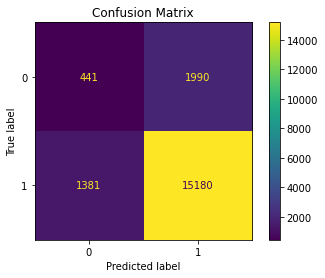

In [120]:
label = [0, 1]
plot = plot_confusion_matrix(clf2,
                             X_test_sc, y_test,
                             display_labels = label,
                             normalize = None)
plot.ax_.set_title('Confusion Matrix')

In [122]:
predict_prob1 = clf2.predict_proba(X_test_sc)[:, 1]

In [127]:
threshold = 0.52

prediction1 = predict_prob1 >= threshold

print(classification_report(y_test, prediction1))

              precision    recall  f1-score   support

           0       0.20      0.20      0.20      2431
           1       0.88      0.88      0.88     16561

    accuracy                           0.79     18992
   macro avg       0.54      0.54      0.54     18992
weighted avg       0.79      0.79      0.79     18992



In [133]:
confusion_matrix(y_test, prediction1)

array([[  486,  1945],
       [ 1965, 14596]])

결과적으로 하이퍼파라미터 조절 후 진행한 결과에 대해서는 원래 기초 제작한 모델에 비해 성능이 좋다고 말할 수가 없다. 이는 가뭄예측에 대한 정확한 true 값과 predict 값에 대해 오히려 좋지 못한 결과를 보이기 때문이다. 

그 후 임계치 조절을 통한 최적 임계치를 찾아 냈지만, 이 역시 원래 기본 모델에 비해 많이 성능이 떨어진다고 볼 수가있다.

그렇기 때문에 원래 사용한 기본모델을 사용한다.